# Artist-grouped stratified split for language classification

Keunwoo Choi, 2020-12-28

In music classification task, it's usually more rigorous to separate artists in training vs testing sets -- in other words, an artist should be included only one of the splits. This is because the ML model can (softly) cheat by finding correlation between tracks of an artist and use it as a cue. (Related: ML models are surprisingly good at artist classification task)

This is called `grouped` split, and that is what we're doing in this notebook.

In [1]:
import sklearn
print(sklearn.__version__)

0.24.0


In [2]:
from sklearn.model_selection._split import _BaseKFold, check_random_state, type_of_target, column_or_1d
from collections import defaultdict
import warnings

In [3]:
# forked from https://github.com/scikit-learn/scikit-learn/pull/18649

class StratifiedGroupKFold(_BaseKFold):
    """Stratified K-Folds iterator variant with non-overlapping groups.
    This cross-validation object is a variation of StratifiedKFold that returns
    stratified folds with non-overlapping groups. The folds are made by
    preserving the percentage of samples for each class.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    The difference between GroupKFold and StratifiedGroupKFold is that
    the former attempts to create balanced folds such that the number of
    distinct groups is approximately the same in each fold, whereas
    StratifiedGroupKFold attempts to create folds which preserve the
    percentage of samples for each class as much as possible given the
    constraint of non-overlapping groups between splits.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of folds. Must be at least 2.
    shuffle : bool, default=False
        Whether to shuffle each class's samples before splitting into batches.
        Note that the samples within each split will not be shuffled.
        This implementation can only shuffle groups that have approximately the
        same y distribution, no global shuffle will be performed.
    random_state : int or RandomState instance, default=None
        When `shuffle` is True, `random_state` affects the ordering of the
        indices, which controls the randomness of each fold for each class.
        Otherwise, leave `random_state` as `None`.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import StratifiedGroupKFold
    >>> X = np.ones((17, 2))
    >>> y = np.array([0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    >>> groups = np.array([1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 5, 5, 6, 6, 7, 8, 8])
    >>> cv = StratifiedGroupKFold(n_splits=3)
    >>> for train_idxs, test_idxs in cv.split(X, y, groups):
    ...     print("TRAIN:", groups[train_idxs])
    ...     print("      ", y[train_idxs])
    ...     print(" TEST:", groups[test_idxs])
    ...     print("      ", y[test_idxs])
    TRAIN: [1 1 2 2 4 5 5 5 5 8 8]
           [0 0 1 1 1 0 0 0 0 0 0]
     TEST: [3 3 3 6 6 7]
           [1 1 1 0 0 0]
    TRAIN: [3 3 3 4 5 5 5 5 6 6 7]
           [1 1 1 1 0 0 0 0 0 0 0]
     TEST: [1 1 2 2 8 8]
           [0 0 1 1 0 0]
    TRAIN: [1 1 2 2 3 3 3 6 6 7 8 8]
           [0 0 1 1 1 1 1 0 0 0 0 0]
     TEST: [4 5 5 5 5]
           [1 0 0 0 0]
    Notes
    -----
    The implementation is designed to:
    * Mimic the behavior of StratifiedKFold as much as possible for trivial
      groups (e.g. when each group contain only one sample).
    * Be invariant to class label: relabelling ``y = ["Happy", "Sad"]`` to
      ``y = [1, 0]`` should not change the indices generated.
    * Stratify based on samples as much as possible while keeping
      non-overlapping groups constraint. That means that in some cases when
      there is a small number of groups containing a large number of samples
      the stratification will not be possible and the behavior will be close
      to GroupKFold.
    * Implementation is based on this kaggle kernel:
      https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation
      Changelist:
      - Refactored function to a class following scikit-learn KFold interface.
      - Added heuristic for assigning group to the least populated fold in
        cases when all other criteria are equal
      - Swtch from using python ``Counter`` to ``np.unique`` to get class
        distribution
      - Added scikit-learn checks for input: checking that target is binary or
        multiclass, checking passed random state, checking that number of
        splits is less than number of members in each class, checking that
        least populated class has more members than there are splits.
    See also
    --------
    StratifiedKFold: Takes class information into account to build folds which
        retain class distributions (for binary or multiclass classification
        tasks).
    GroupKFold: K-fold iterator variant with non-overlapping groups.
    """

    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        super().__init__(n_splits=n_splits, shuffle=shuffle,
                         random_state=random_state)

    def _iter_test_indices(self, X, y, groups):
        rng = check_random_state(self.random_state)
        y = np.asarray(y)
        type_of_target_y = type_of_target(y)
        allowed_target_types = ('binary', 'multiclass')
        if type_of_target_y not in allowed_target_types:
            raise ValueError(
                'Supported target types are: {}. Got {!r} instead.'.format(
                    allowed_target_types, type_of_target_y))

        y = column_or_1d(y)
        _, y_inv, y_cnt = np.unique(y, return_inverse=True, return_counts=True)
        if np.all(self.n_splits > y_cnt):
            raise ValueError("n_splits=%d cannot be greater than the"
                             " number of members in each class."
                             % (self.n_splits))
        n_smallest_class = np.min(y_cnt)
        if self.n_splits > n_smallest_class:
            warnings.warn(("The least populated class in y has only %d"
                           " members, which is less than n_splits=%d."
                           % (n_smallest_class, self.n_splits)), UserWarning)
        labels_num = len(y_cnt)
        y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
        for label, group in zip(y_inv, groups):
            y_counts_per_group[group][label] += 1

        y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
        groups_per_fold = defaultdict(set)

        groups_and_y_counts = list(y_counts_per_group.items())
        if self.shuffle:
            rng.shuffle(groups_and_y_counts)

        for group, y_counts in sorted(groups_and_y_counts,
                                      key=lambda x: -np.std(x[1])):
            best_fold = None
            min_eval = np.inf
            min_samples_in_fold = np.inf
            for i in range(self.n_splits):
                y_counts_per_fold[i] += y_counts
                std_per_label = []
                for label in range(labels_num):
                    std_per_label.append(np.std(
                        [y_counts_per_fold[j][label] / y_cnt[label]
                         for j in range(self.n_splits)]))
                y_counts_per_fold[i] -= y_counts
                fold_eval = np.mean(std_per_label)
                samples_in_fold = np.sum(y_counts_per_fold[i])
                is_current_fold_better = (
                    np.isclose(fold_eval, min_eval)
                    and samples_in_fold < min_samples_in_fold
                    or fold_eval < min_eval
                )
                if is_current_fold_better:
                    min_eval = fold_eval
                    min_samples_in_fold = samples_in_fold
                    best_fold = i
            y_counts_per_fold[best_fold] += y_counts
            groups_per_fold[best_fold].add(group)

        for i in range(self.n_splits):
            test_indices = [idx for idx, group in enumerate(groups)
                            if group in groups_per_fold[i]]
            yield test_indices


In [6]:
import os
import sys
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn

plt.style.use('seaborn')

CSV_FOLDER = '../id_csvs/'
LANG_DIR = '../split-language_only-artist_grouped'
SPLIT_DIR = '../split-all_labels'
FIG_DIR = '../figures'

font = {'size': 22}

matplotlib.rc('font', **font)

In [7]:
os.makedirs(LANG_DIR, exist_ok=True)
os.makedirs(SPLIT_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

In [8]:
def write_txt(path, list_of_str):
    with open(path, 'w') as f:
        for value in list_of_str:
            f.write(value)
            f.write('\n')
            

In [13]:
df_lang = pd.read_csv(os.path.join(CSV_FOLDER, 'id_lang.csv'), header=0, sep='	')
df_meta = pd.read_csv(os.path.join(CSV_FOLDER, 'id_metadata.csv'), header=0, sep='	')
df_info = pd.read_csv(os.path.join(CSV_FOLDER, 'id_information.csv'), header=0, sep='	')

In [14]:
df_langg = df_lang.merge(df_info, on='id').merge(df_meta)
df_langg

,id,lang,artist,song,album_name,spotify_id,popularity,release,danceability,energy,key,mode,valence,tempo,duration_ms
0,0009fFIM1eYThaPg,en,Cheryl,Rain on Me,3 Words,3eObKIfHKJ1nAPh0wTxFCc,12.0,2009,0.635,0.746,6.0,1.0,0.548,110.973,229947
1,0010xmHR6UICBOYT,en,Oddisee,After Thoughts,The Beauty in All,27szvF97Tu95GxN98N52fy,46.0,2013,0.591,0.513,7.0,0.0,0.263,172.208,325096
2,002Jyd0vN4HyCpqL,en,Blue Öyster Cult,ME 262,Secret Treaties,273lBFpxUCwisTpdnF9cVb,31.0,1974,0.319,0.925,2.0,1.0,0.658,157.630,285693
3,006TYKNjNxWjfKjy,en,Rhapsody,Flames of Revenge,Legendary Years (Re-Recorded),1qZgergQ41vaD4zBf3AKXR,33.0,2017,0.432,0.979,7.0,1.0,0.162,90.008,332867
4,007LIJOPQ4Sb98qV,en,The Chameleons,Nostalgia,What Does Anything Mean? Basically (2009 Remas...,6rVxJ3sN3Cz40MSLavbG1K,19.0,2009,0.357,0.708,9.0,1.0,0.470,123.904,326067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109264,zzyyPUs7hC9Nz2e1,en,Frank Carter & The Rattlesnakes,Vampires,Modern Ruin,6IW5yPlWJYmXxRuuc7QkMx,36.0,2017,0.380,0.835,1.0,1.0,0.539,142.699,200880
109265,zzz0n04uuTUA7fNh,en,Justin Bieber,Heartbreaker,Journals,21pCToQdqcPi879auxjxKe,48.0,2014,0.572,0.503,6.0,0.0,0.553,103.215,262840
109266,zzzj3LYaZtYtbzSr,en,Regina Spektor,Après Moi - Live In London,Live In London,2SJ6FGmRPacKE9N4g4BRZU,21.0,2010,0.402,0.376,2.0,0.0,0.119,108.509,276507
109267,zzznMjZAKnJJXQSj,en,Dua Lipa,New Rules (Initial Talk Remix),New Rules (Initial Talk Remix),2ygfHXyt3gvyhvKrNJU61n,47.0,2017,0.532,0.977,10.0,0.0,0.966,116.527,224549


Btw - this is the occurrence counter of each language

Counter({'en': 84103, 'INTRUMENTAL': 9417, 'pt': 7020, 'es': 3225, 'ko': 1145, 'fr': 994, 'ja': 615, 'de': 577, 'pl': 446, 'it': 437, 'sv': 231, 'ru': 187, 'id': 140, 'tr': 125, 'fi': 105, 'no': 99, 'nl': 59, 'tl': 42, 'hr': 41, 'hu': 27, 'sw': 21, 'uk': 20, 'el': 18, 'ca': 18, 'ro': 18, 'da': 17, 'ar': 17, 'et': 16, 'so': 16, 'vi': 13, 'af': 8, 'lt': 7, 'cy': 7, 'sl': 7, 'fa': 6, 'sq': 5, 'th': 4, 'zh-cn': 4, 'pa': 2, 'lv': 2, 'bn': 2, 'cs': 2, 'hi': 1, 'sk': 1, 'bg': 1, 'he': 1})

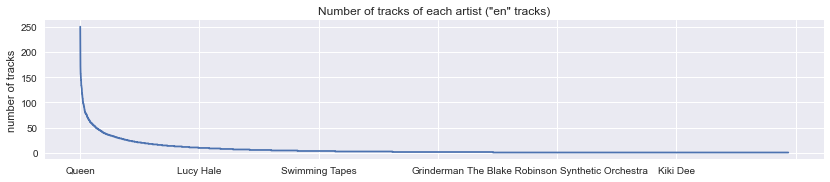

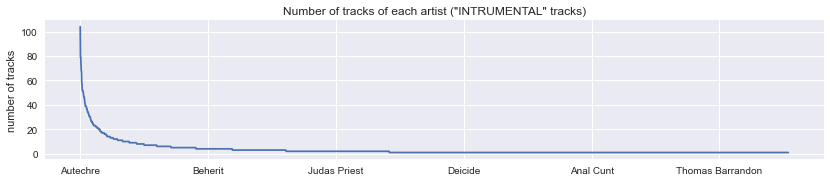

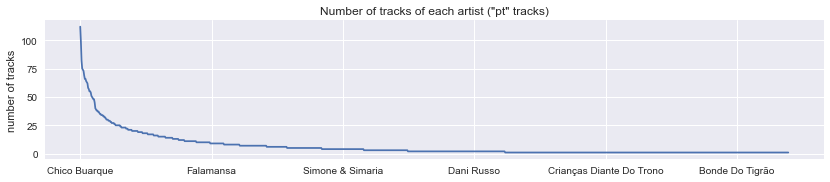

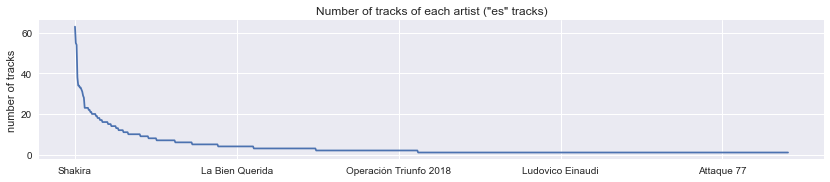

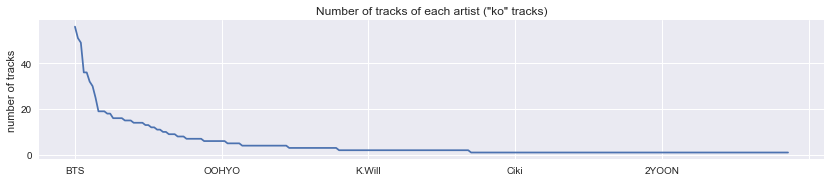

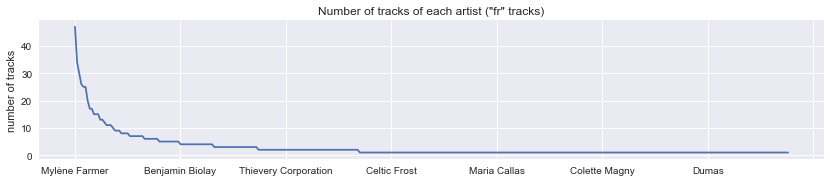

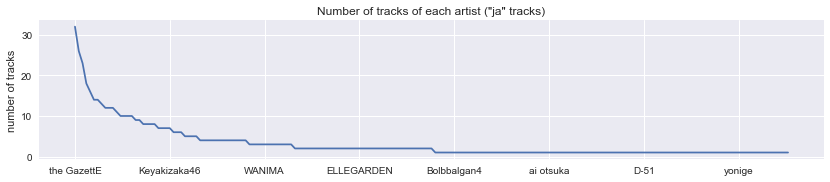

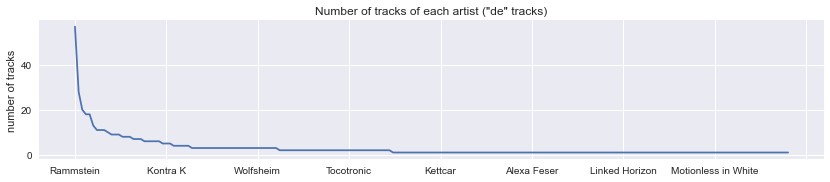

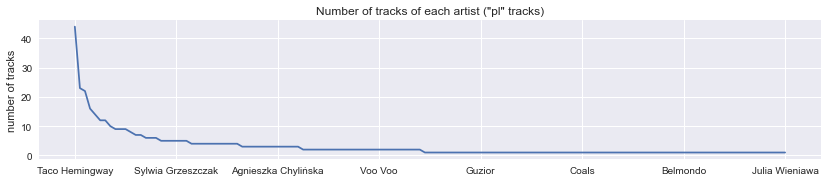

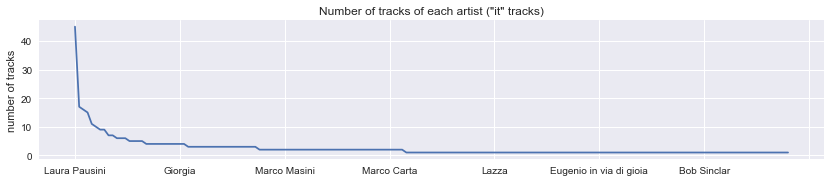

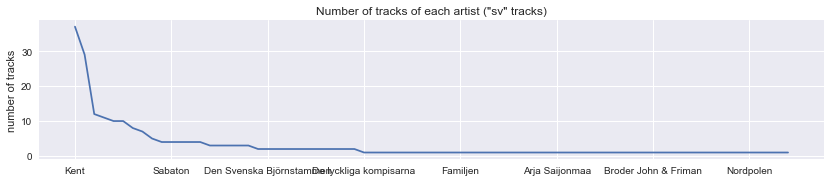

In [15]:
for lang_code in ['en', 'INTRUMENTAL', 'pt', 'es', 'ko', 'fr', 'ja', 'de', 'pl', 'it', 'sv']:
    plt.figure(figsize=(12, 3))
    df_langg[df_langg['lang'] == lang_code]['artist'].value_counts().plot(
        title=f'Number of tracks of each artist ("{lang_code}" tracks)', 
        ylabel='number of tracks',
    )
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f'number-of-tracks-by-artist_language={lang_code}.png'))
    print('')

# Split

In [16]:
df_langgg = df_langg[['id', 'lang', 'artist']]
df_langgg.head()

,id,lang,artist
0,0009fFIM1eYThaPg,en,Cheryl
1,0010xmHR6UICBOYT,en,Oddisee
2,002Jyd0vN4HyCpqL,en,Blue Öyster Cult
3,006TYKNjNxWjfKjy,en,Rhapsody
4,007LIJOPQ4Sb98qV,en,The Chameleons


In [17]:
np.random.seed(1209)
skf = StratifiedGroupKFold(n_splits=5)  # 20% for test set

splits = []

for train_index, test_index in skf.split(df_langgg['id'], df_langgg['lang'], groups=df_langgg['artist']):
    print("TRAIN:", train_index, "TEST:", test_index)
    splits.append({'train': train_index, 'test': test_index})

/Users/admin/miniconda3/envs/music4all_contrib/lib/python3.7/site-packages/ipykernel_launcher.py:113: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.


TRAIN: [     0      1      2 ... 109265 109266 109268] TEST: [    10     19     20 ... 109254 109261 109267]
TRAIN: [     0      1      3 ... 109266 109267 109268] TEST: [     2      6     11 ... 109235 109241 109259]
TRAIN: [     0      2      5 ... 109266 109267 109268] TEST: [     1      3      4 ... 109260 109263 109264]
TRAIN: [     0      1      2 ... 109263 109264 109267] TEST: [     5      8      9 ... 109265 109266 109268]
TRAIN: [     1      2      3 ... 109266 109267 109268] TEST: [     0      7     12 ... 109237 109245 109262]


In [18]:
primary_language_split = splits[0]

In [19]:
# double-check!
artist_names_training = set(df_langgg.loc[primary_language_split['train']]['artist'])
artist_names_testing = set(df_langgg.loc[primary_language_split['test']]['artist'])

assert artist_names_training.intersection(artist_names_testing) == set()
print('There is no overlapping artists in training / testing sets')

There is no overlapping artists in training / testing sets


In [20]:
df_lang_train = df_lang.iloc[primary_language_split['train']]
print(len(df_lang_train))
df_lang_test = df_lang.iloc[primary_language_split['test']]
print(len(df_lang_test))

87416
21853


In [22]:
def analyze_genre_tag_df(df, top_n=100):
    """plot the occurrences of top_n items in the given df"""
    def get_counter(items: list):
        """items: list of list"""    
        items = [g.split(',') for g in items]
        items = [item for sublist in items for item in sublist]
        items = Counter(items)    
        return items
    
    def plot_freqs(counter: Counter, top_n, title=''):
        most_common = counter.most_common(top_n)
        names, counts = list(zip(*most_common))

        xs = np.arange(len(names))
        plt.figure(figsize=(18, 7))
        plt.bar(xs, counts)
        plt.xticks(xs + 0.2, names, rotation=60, size=17, ha='right') 
        plt.title('Top-%d %s (out of %d in total)' % (top_n, title, len(counter)), size=20)
        plt.ylabel('occurrence', size=17)
        
    column_name = df.columns[1]
    labels = df[column_name].tolist()
    labels = get_counter(labels)
    
    print('Number of %s: %d' % (column_name, len(labels)))

    plot_freqs(labels, top_n=top_n, title=column_name)
    return labels
    
def analyze_genre_tag_csv(csv_path, top_n):
    """wrapper of analyze_genre_tag_df"""
    basename = os.path.basename(csv_path)
    df = pd.read_csv(os.path.join(CSV_FOLDER, csv_path), header=0, sep='	')
    df.head()
    return analyze_genre_tag_df(df, top_n=top_n)

Number of lang: 44


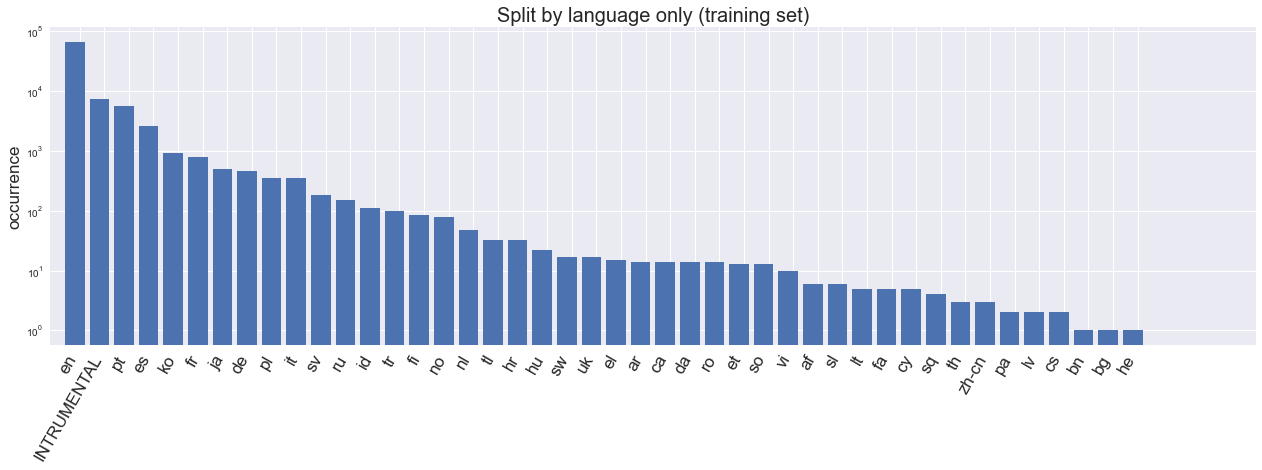

In [23]:
lang_train_counter = analyze_genre_tag_df(df_lang_train, top_n=46)
plt.yscale('log')
plt.xlim([-1, 48])
plt.tight_layout()
plt.title('Split by language only (training set)', size=20)
plt.savefig(os.path.join(FIG_DIR, 'occurrence--split-language_only-artist_grouped-training-log.png'))

Number of lang: 41


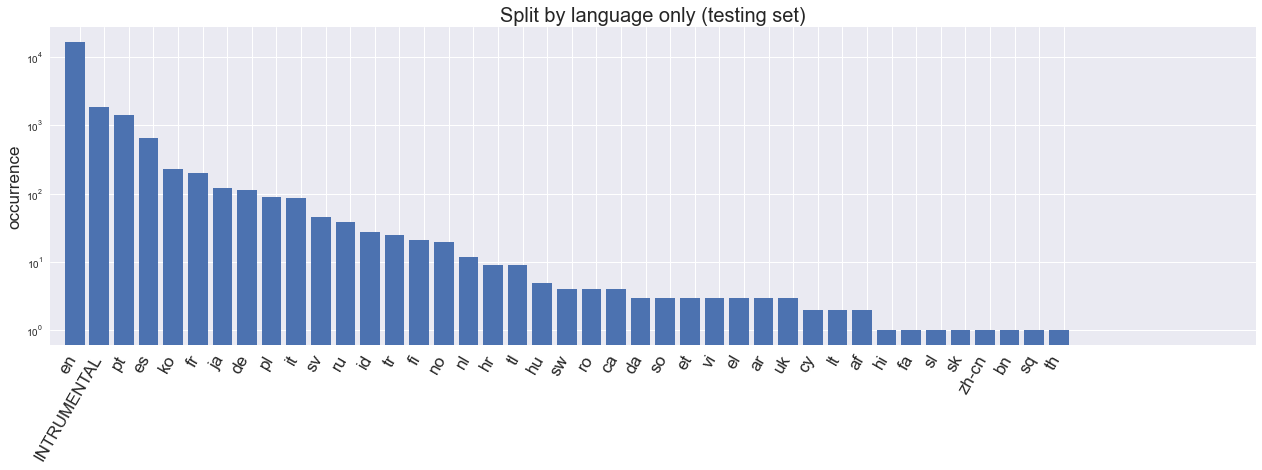

In [24]:
lang_test_counter = analyze_genre_tag_df(df_lang_test)
plt.yscale('log')
plt.xlim([-1, 48])
plt.tight_layout()
plt.title('Split by language only (testing set)', size=20)
plt.savefig(os.path.join(FIG_DIR, 'occurrence--split-language_only-artist_grouped-testing-log.png'))

In [25]:
print('Because some language only has 1-2 data points, only these %d languages exist both '
      'in training and test sets (sorted by occurrence count).' %
     len(lang_test_counter))
print((lang_test_counter.keys()))

lang_tags_to_exclude = set(lang_train_counter.keys()).difference(set(lang_test_counter.keys()))
print('In other words, exclude (at least) these languages:', lang_tags_to_exclude)

Because some language only has 1-2 data points, only these 41 languages exist both in training and test sets (sorted by occurrence count).
dict_keys(['en', 'INTRUMENTAL', 'it', 'ko', 'pt', 'es', 'fr', 'da', 'ja', 'de', 'pl', 'cy', 'ru', 'sv', 'hr', 'id', 'hi', 'tl', 'fa', 'lt', 'tr', 'no', 'nl', 'fi', 'so', 'et', 'sw', 'hu', 'ro', 'vi', 'ca', 'el', 'sl', 'ar', 'uk', 'sk', 'zh-cn', 'bn', 'sq', 'af', 'th'])
In other words, exclude (at least) these languages: {'pa', 'lv', 'he', 'cs', 'bg'}


In [26]:
# Save the outputs
for split in ['train', 'test']:
    write_txt(path=os.path.join(LANG_DIR, split + '.txt'),
             list_of_str=[str(index) for index in primary_language_split[split]])